# Import

In [1]:
import os
import sys

import time
import math
import json
import glob
from datetime import datetime

import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize, least_squares
import matplotlib.pyplot as plt

import cv2
import torch
from torch.nn.functional import mse_loss
from pytorch_kinematics.transforms.rotation_conversions import matrix_to_axis_angle, axis_angle_to_matrix

import pytorch_kinematics as pk
from pytransform3d.urdf import UrdfTransformManager
from urdf_parser_py.urdf import URDF

# Helper Functions

In [2]:
def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

def forward_kinematics(V, 
                       cmd_lnt, cmd_lnp, cmd_unt, cmd_et, cmd_lep, cmd_rep,
                       robot,var2idx):
    
    # Convert to Tensor
    cmd_lnt = torch.Tensor(cmd_lnt).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_lnp = torch.Tensor(cmd_lnp).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_unt = torch.Tensor(cmd_unt).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_et = torch.Tensor(cmd_et).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_lep = torch.Tensor(cmd_lep).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_rep = torch.Tensor(cmd_rep).reshape(-1,1).to(dtype=dtype, device=device)

    #Joint-to-Motor Polynomial Models
    neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt @ torch.Tensor([V[var2idx['neck_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp @ torch.Tensor([V[var2idx['neck_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt @ torch.Tensor([V[var2idx['head_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et @ torch.Tensor([V[var2idx['eyes_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep @ torch.Tensor([V[var2idx['lefteye_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep @ torch.Tensor([V[var2idx['righteye_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)

    # URDF Variable Assignment
    for joint in robot.joints:
        if joint.name == 'torso':
            joint.origin.position[0] = V[var2idx['torso_origin_x']]
            joint.origin.position[1] = V[var2idx['torso_origin_y']]
            joint.origin.position[2] = V[var2idx['torso_origin_z']]
        elif joint.name == 'neck_pitch':
            joint.origin.rotation[0] = V[var2idx['neck_pitch_rot_r']]
        elif joint.name == 'head_pitch':
            joint.origin.position[2] = V[var2idx['head_pitch_origin_z']]
        elif joint.name == 'eyes_pitch':
            joint.origin.position[0] = V[var2idx['eyes_pitch_origin_x']]
            joint.origin.position[2] = V[var2idx['eyes_pitch_origin_z']]
        elif joint.name == 'lefteye_yaw':
            joint.origin.position[1] = V[var2idx['lefteye_yaw_origin_y']]
        elif joint.name == 'righteye_yaw':
            joint.origin.position[1] = -V[var2idx['lefteye_yaw_origin_y']]
        elif joint.name == 'lefteye_cam':
            joint.origin.position[0] = V[var2idx['lefteye_cam_origin_x']]
            joint.origin.rotation[0] = V[var2idx['lefteye_cam_rot_r']]
            joint.origin.rotation[2] = V[var2idx['lefteye_cam_rot_y']]
        elif joint.name == 'righteye_cam':
            joint.origin.position[0] = V[var2idx['righteye_cam_origin_x']]
            joint.origin.rotation[0] = V[var2idx['righteye_cam_rot_r']]
            joint.origin.rotation[2] = V[var2idx['righteye_cam_rot_y']]
    
    # XML to String
    urdf_str = xml_to_str(robot)
    
    # Kinematic Chain
    chain = pk.build_chain_from_urdf(urdf_str)
    chain.to(dtype=dtype, device=device)
    
    # Specifying Joint Angles (radians)
    joint_cmd = torch.cat((neck_pitch.reshape(-1,1), neck_yaw.reshape(-1,1), head_pitch.reshape(-1,1), eyes_pitch.reshape(-1,1), lefteye_yaw.reshape(-1,1), righteye_yaw.reshape(-1,1)), dim=1)

    # Forward Kinematics
    ret = chain.forward_kinematics(joint_cmd)

    # Realsense to Left Eye Camera (Pytorch) with Points
    T_clprime = torch.linalg.inv(ret['leftcamera'].get_matrix()) @ ret['realsense'].get_matrix()
    
    # Realsense to Right Eye Camera (Pytorch) with Points
    T_crprime = torch.linalg.inv(ret['rightcamera'].get_matrix()) @ ret['realsense'].get_matrix()

    # Rvec and Tvec
    out_l_rvec = matrix_to_axis_angle(T_clprime[:,:3,:3])
    out_l_tvec = T_clprime[:,:3,3]
    out_r_rvec = matrix_to_axis_angle(T_crprime[:,:3,:3])
    out_r_tvec = T_crprime[:,:3,3]

    # Return Output
    return out_l_rvec, out_l_tvec, out_r_rvec, out_r_tvec


def get_total_loss(data_dir, data_csv, fit_result):
    # Load Dataset CSV
    csv_file = os.path.join(os.getcwd(),"..","data", data_dir, data_csv)
    temp_df = pd.read_csv(csv_file)
    
    # Convert DF Degrees Column to Radians
    data_df = temp_df.copy()
    data_df['cmd_theta_lower_neck_pan'] = np.radians(data_df['cmd_theta_lower_neck_pan'].values)
    data_df['cmd_theta_lower_neck_tilt'] = np.radians(data_df['cmd_theta_lower_neck_tilt'].values)
    data_df['cmd_theta_upper_neck_tilt'] = np.radians(data_df['cmd_theta_upper_neck_tilt'].values)
    data_df['cmd_theta_left_eye_pan'] = np.radians(data_df['cmd_theta_left_eye_pan'].values)
    data_df['cmd_theta_right_eye_pan'] = np.radians(data_df['cmd_theta_right_eye_pan'].values)
    data_df['cmd_theta_eyes_tilt'] = np.radians(data_df['cmd_theta_eyes_tilt'].values)
    
    # Load CSV Optimization Results
    csv_path = os.path.join(os.getcwd(),"..","results",data_dir,fit_result)
    csv_df = pd.read_csv(csv_path, index_col=0)
    var_dict = dict(zip(csv_df.index,csv_df['learned'].values))
    
    # Decision Variables 
    var_list = list(var_dict.values())

    # Variable Names
    var_names_list = list(var_dict.keys())

    # Mapping
    idx2var = dict(zip(list(range(len(var_names_list))),var_names_list))
    var2idx = dict(zip(var_names_list, list(range(len(var_names_list)))))
    
    # Input
    V = np.array(var_list)
    x_c_l = data_df['x_c_l'].to_numpy()
    y_c_l = data_df['y_c_l'].to_numpy()
    z_c_l = data_df['z_c_l'].to_numpy()
    x_c_r = data_df['x_c_r'].to_numpy()
    y_c_r = data_df['y_c_r'].to_numpy()
    z_c_r = data_df['z_c_r'].to_numpy()
    cmd_lnt = data_df['cmd_theta_lower_neck_tilt'].to_numpy()
    cmd_lnp = data_df['cmd_theta_lower_neck_pan'].to_numpy()
    cmd_unt = data_df['cmd_theta_upper_neck_tilt'].to_numpy()
    cmd_et = data_df['cmd_theta_eyes_tilt'].to_numpy()
    cmd_lep = data_df['cmd_theta_left_eye_pan'].to_numpy()
    cmd_rep = data_df['cmd_theta_right_eye_pan'].to_numpy()

    l_rvec = np.concatenate([data_df['l_rvec_0'].values.reshape(-1,1),
                             data_df['l_rvec_1'].values.reshape(-1,1),
                             data_df['l_rvec_2'].values.reshape(-1,1)], axis=1)
    l_tvec = np.concatenate([data_df['l_tvec_0'].values.reshape(-1,1),
                             data_df['l_tvec_1'].values.reshape(-1,1),
                             data_df['l_tvec_2'].values.reshape(-1,1)], axis=1)
    r_rvec = np.concatenate([data_df['r_rvec_0'].values.reshape(-1,1),
                             data_df['r_rvec_1'].values.reshape(-1,1),
                             data_df['r_rvec_2'].values.reshape(-1,1)], axis=1)
    r_tvec = np.concatenate([data_df['r_tvec_0'].values.reshape(-1,1),
                             data_df['r_tvec_1'].values.reshape(-1,1),
                             data_df['r_tvec_2'].values.reshape(-1,1)], axis=1)
    
    # Forward Kinematics
    out_l_rvec, out_l_tvec, out_r_rvec, out_r_tvec = forward_kinematics(V, 
                                                                        cmd_lnt, cmd_lnp, cmd_unt, cmd_et, cmd_lep, cmd_rep,
                                                                        robot,var2idx)
    # True Value
    out_l_rvec = out_l_rvec.to(dtype=dtype, device=device)
    out_l_tvec = out_l_tvec.to(dtype=dtype, device=device)
    out_r_rvec = out_r_rvec.to(dtype=dtype, device=device)
    out_r_tvec = out_r_tvec.to(dtype=dtype, device=device)
    
    # True Value
    l_rvec_t = torch.Tensor(l_rvec).to(dtype=dtype, device=device)
    l_tvec_t = torch.Tensor(l_tvec).to(dtype=dtype, device=device)
    r_rvec_t = torch.Tensor(r_rvec).to(dtype=dtype, device=device)
    r_tvec_t = torch.Tensor(r_tvec).to(dtype=dtype, device=device)
    
    # Results
    results_idx = ['r(rad)','p(rad)', 'y(rad)', 'x(cm)','y(cm)', 'z(cm)',]
    results_df = pd.DataFrame({'Left Eye RMSE': [
                                math.sqrt(mse_loss(out_l_rvec[:,0], l_rvec_t[:,0]).cpu().item()),
                                math.sqrt(mse_loss(out_l_rvec[:,1], l_rvec_t[:,1]).cpu().item()),
                                math.sqrt(mse_loss(out_l_rvec[:,2], l_rvec_t[:,2]).cpu().item()),
                                math.sqrt(mse_loss(100*out_l_tvec[:,0], 100*l_tvec_t[:,0]).cpu().item()),
                                math.sqrt(mse_loss(100*out_l_tvec[:,1], 100*l_tvec_t[:,1]).cpu().item()),
                                math.sqrt(mse_loss(100*out_l_tvec[:,2], 100*l_tvec_t[:,2]).cpu().item()),
                                ],
                              'Right Eye RMSE': [
                                math.sqrt(mse_loss(out_r_rvec[:,0], r_rvec_t[:,0]).cpu().item()),
                                math.sqrt(mse_loss(out_r_rvec[:,1], r_rvec_t[:,1]).cpu().item()),
                                math.sqrt(mse_loss(out_r_rvec[:,2], r_rvec_t[:,2]).cpu().item()),
                                math.sqrt(mse_loss(100*out_r_tvec[:,0], 100*r_tvec_t[:,0]).cpu().item()),
                                math.sqrt(mse_loss(100*out_r_tvec[:,1], 100*r_tvec_t[:,1]).cpu().item()),
                                math.sqrt(mse_loss(100*out_r_tvec[:,2], 100*r_tvec_t[:,2]).cpu().item()),
                              ],
                              'Left Eye MSE': [
                                mse_loss(out_l_rvec[:,0], l_rvec_t[:,0]).cpu().item(),
                                mse_loss(out_l_rvec[:,1], l_rvec_t[:,1]).cpu().item(),
                                mse_loss(out_l_rvec[:,2], l_rvec_t[:,2]).cpu().item(),
                                mse_loss(out_l_tvec[:,0], l_tvec_t[:,0]).cpu().item(),
                                mse_loss(out_l_tvec[:,1], l_tvec_t[:,1]).cpu().item(),
                                mse_loss(out_l_tvec[:,2], l_tvec_t[:,2]).cpu().item(),
                                ],
                              'Right Eye MSE': [
                                mse_loss(out_r_rvec[:,0], r_rvec_t[:,0]).cpu().item(),
                                mse_loss(out_r_rvec[:,1], r_rvec_t[:,1]).cpu().item(),
                                mse_loss(out_r_rvec[:,2], r_rvec_t[:,2]).cpu().item(),
                                mse_loss(out_r_tvec[:,0], r_tvec_t[:,0]).cpu().item(),
                                mse_loss(out_r_tvec[:,1], r_tvec_t[:,1]).cpu().item(),
                                mse_loss(out_r_tvec[:,2], r_tvec_t[:,2]).cpu().item(),
                                ],
                              })
    results_df.index = results_idx
    
    return results_df


def forward_kinematics_frozen(V, 
                       cmd_lnt, cmd_lnp, cmd_unt, cmd_et, cmd_lep, cmd_rep,
                       robot,var2idx):
    
    # Convert to Tensor
    cmd_lnt = torch.Tensor(cmd_lnt).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_lnp = torch.Tensor(cmd_lnp).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_unt = torch.Tensor(cmd_unt).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_et = torch.Tensor(cmd_et).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_lep = torch.Tensor(cmd_lep).reshape(-1,1).to(dtype=dtype, device=device)
    cmd_rep = torch.Tensor(cmd_rep).reshape(-1,1).to(dtype=dtype, device=device)

    #Joint-to-Motor Polynomial Models
    neck_pitch = V[var2idx['neck_pitch_polyfit_b0']] + cmd_lnt @ torch.Tensor([V[var2idx['neck_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    neck_yaw = V[var2idx['neck_yaw_polyfit_b0']] + cmd_lnp @ torch.Tensor([V[var2idx['neck_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    head_pitch = V[var2idx['head_pitch_polyfit_b0']] + cmd_unt @ torch.Tensor([V[var2idx['head_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    eyes_pitch = V[var2idx['eyes_pitch_polyfit_b0']] + cmd_et @ torch.Tensor([V[var2idx['eyes_pitch_polyfit_b1']]]).to(dtype=dtype, device=device)
    lefteye_yaw = V[var2idx['lefteye_yaw_polyfit_b0']] + cmd_lep @ torch.Tensor([V[var2idx['lefteye_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    righteye_yaw = V[var2idx['righteye_yaw_polyfit_b0']] + cmd_rep @ torch.Tensor([V[var2idx['righteye_yaw_polyfit_b1']]]).to(dtype=dtype, device=device)
    
    # XML to String
    urdf_str = xml_to_str(robot)
    
    # Kinematic Chain
    chain = pk.build_chain_from_urdf(urdf_str)
    chain.to(dtype=dtype, device=device)
    
    # Specifying Joint Angles (radians)
    joint_cmd = torch.cat((neck_pitch.reshape(-1,1), neck_yaw.reshape(-1,1), head_pitch.reshape(-1,1), eyes_pitch.reshape(-1,1), lefteye_yaw.reshape(-1,1), righteye_yaw.reshape(-1,1)), dim=1)

    # Forward Kinematics
    ret = chain.forward_kinematics(joint_cmd)

    # Realsense to Left Eye Camera (Pytorch) with Points
    T_clprime = torch.linalg.inv(ret['leftcamera'].get_matrix()) @ ret['realsense'].get_matrix()
    
    # Realsense to Right Eye Camera (Pytorch) with Points
    T_crprime = torch.linalg.inv(ret['rightcamera'].get_matrix()) @ ret['realsense'].get_matrix()

    # Rvec and Tvec
    out_l_rvec = matrix_to_axis_angle(T_clprime[:,:3,:3])
    out_l_tvec = T_clprime[:,:3,3]
    out_r_rvec = matrix_to_axis_angle(T_crprime[:,:3,:3])
    out_r_tvec = T_crprime[:,:3,3]

    # Return Output
    return out_l_rvec, out_l_tvec, out_r_rvec, out_r_tvec

def get_total_loss_frozen(data_dir, data_csv, fit_result):
    # Load Dataset CSV
    csv_file = os.path.join(os.getcwd(),"..","data", data_dir, data_csv)
    temp_df = pd.read_csv(csv_file)
    
    # Convert DF Degrees Column to Radians
    data_df = temp_df.copy()
    data_df['cmd_theta_lower_neck_pan'] = np.radians(data_df['cmd_theta_lower_neck_pan'].values)
    data_df['cmd_theta_lower_neck_tilt'] = np.radians(data_df['cmd_theta_lower_neck_tilt'].values)
    data_df['cmd_theta_upper_neck_tilt'] = np.radians(data_df['cmd_theta_upper_neck_tilt'].values)
    data_df['cmd_theta_left_eye_pan'] = np.radians(data_df['cmd_theta_left_eye_pan'].values)
    data_df['cmd_theta_right_eye_pan'] = np.radians(data_df['cmd_theta_right_eye_pan'].values)
    data_df['cmd_theta_eyes_tilt'] = np.radians(data_df['cmd_theta_eyes_tilt'].values)
    
    # Load CSV Optimization Results
    csv_path = os.path.join(os.getcwd(),"..","results",data_dir,fit_result)
    csv_df = pd.read_csv(csv_path, index_col=0)
    var_dict = dict(zip(csv_df.index,csv_df['learned'].values))
    
    # Decision Variables 
    var_list = list(var_dict.values())

    # Variable Names
    var_names_list = list(var_dict.keys())

    # Mapping
    idx2var = dict(zip(list(range(len(var_names_list))),var_names_list))
    var2idx = dict(zip(var_names_list, list(range(len(var_names_list)))))
    
    # Input
    V = np.array(var_list)
    x_c_l = data_df['x_c_l'].to_numpy()
    y_c_l = data_df['y_c_l'].to_numpy()
    z_c_l = data_df['z_c_l'].to_numpy()
    x_c_r = data_df['x_c_r'].to_numpy()
    y_c_r = data_df['y_c_r'].to_numpy()
    z_c_r = data_df['z_c_r'].to_numpy()
    cmd_lnt = data_df['cmd_theta_lower_neck_tilt'].to_numpy()
    cmd_lnp = data_df['cmd_theta_lower_neck_pan'].to_numpy()
    cmd_unt = data_df['cmd_theta_upper_neck_tilt'].to_numpy()
    cmd_et = data_df['cmd_theta_eyes_tilt'].to_numpy()
    cmd_lep = data_df['cmd_theta_left_eye_pan'].to_numpy()
    cmd_rep = data_df['cmd_theta_right_eye_pan'].to_numpy()

    l_rvec = np.concatenate([data_df['l_rvec_0'].values.reshape(-1,1),
                             data_df['l_rvec_1'].values.reshape(-1,1),
                             data_df['l_rvec_2'].values.reshape(-1,1)], axis=1)
    l_tvec = np.concatenate([data_df['l_tvec_0'].values.reshape(-1,1),
                             data_df['l_tvec_1'].values.reshape(-1,1),
                             data_df['l_tvec_2'].values.reshape(-1,1)], axis=1)
    r_rvec = np.concatenate([data_df['r_rvec_0'].values.reshape(-1,1),
                             data_df['r_rvec_1'].values.reshape(-1,1),
                             data_df['r_rvec_2'].values.reshape(-1,1)], axis=1)
    r_tvec = np.concatenate([data_df['r_tvec_0'].values.reshape(-1,1),
                             data_df['r_tvec_1'].values.reshape(-1,1),
                             data_df['r_tvec_2'].values.reshape(-1,1)], axis=1)
    
    # Forward Kinematics
    out_l_rvec, out_l_tvec, out_r_rvec, out_r_tvec = forward_kinematics_frozen(V, 
                                                                        cmd_lnt, cmd_lnp, cmd_unt, cmd_et, cmd_lep, cmd_rep,
                                                                        robot,var2idx)
    # True Value
    out_l_rvec = out_l_rvec.to(dtype=dtype, device=device)
    out_l_tvec = out_l_tvec.to(dtype=dtype, device=device)
    out_r_rvec = out_r_rvec.to(dtype=dtype, device=device)
    out_r_tvec = out_r_tvec.to(dtype=dtype, device=device)
    
    # True Value
    l_rvec_t = torch.Tensor(l_rvec).to(dtype=dtype, device=device)
    l_tvec_t = torch.Tensor(l_tvec).to(dtype=dtype, device=device)
    r_rvec_t = torch.Tensor(r_rvec).to(dtype=dtype, device=device)
    r_tvec_t = torch.Tensor(r_tvec).to(dtype=dtype, device=device)
    
    # Results
    results_idx = ['r(rad)','p(rad)', 'y(rad)', 'x(cm)','y(cm)', 'z(cm)',]
    results_df = pd.DataFrame({'Left Eye RMSE': [
                                math.sqrt(mse_loss(out_l_rvec[:,0], l_rvec_t[:,0]).cpu().item()),
                                math.sqrt(mse_loss(out_l_rvec[:,1], l_rvec_t[:,1]).cpu().item()),
                                math.sqrt(mse_loss(out_l_rvec[:,2], l_rvec_t[:,2]).cpu().item()),
                                math.sqrt(mse_loss(100*out_l_tvec[:,0], 100*l_tvec_t[:,0]).cpu().item()),
                                math.sqrt(mse_loss(100*out_l_tvec[:,1], 100*l_tvec_t[:,1]).cpu().item()),
                                math.sqrt(mse_loss(100*out_l_tvec[:,2], 100*l_tvec_t[:,2]).cpu().item()),
                                ],
                              'Right Eye RMSE': [
                                math.sqrt(mse_loss(out_r_rvec[:,0], r_rvec_t[:,0]).cpu().item()),
                                math.sqrt(mse_loss(out_r_rvec[:,1], r_rvec_t[:,1]).cpu().item()),
                                math.sqrt(mse_loss(out_r_rvec[:,2], r_rvec_t[:,2]).cpu().item()),
                                math.sqrt(mse_loss(100*out_r_tvec[:,0], 100*r_tvec_t[:,0]).cpu().item()),
                                math.sqrt(mse_loss(100*out_r_tvec[:,1], 100*r_tvec_t[:,1]).cpu().item()),
                                math.sqrt(mse_loss(100*out_r_tvec[:,2], 100*r_tvec_t[:,2]).cpu().item()),
                              ],
                              'Left Eye MSE': [
                                mse_loss(out_l_rvec[:,0], l_rvec_t[:,0]).cpu().item(),
                                mse_loss(out_l_rvec[:,1], l_rvec_t[:,1]).cpu().item(),
                                mse_loss(out_l_rvec[:,2], l_rvec_t[:,2]).cpu().item(),
                                mse_loss(out_l_tvec[:,0], l_tvec_t[:,0]).cpu().item(),
                                mse_loss(out_l_tvec[:,1], l_tvec_t[:,1]).cpu().item(),
                                mse_loss(out_l_tvec[:,2], l_tvec_t[:,2]).cpu().item(),
                                ],
                              'Right Eye MSE': [
                                mse_loss(out_r_rvec[:,0], r_rvec_t[:,0]).cpu().item(),
                                mse_loss(out_r_rvec[:,1], r_rvec_t[:,1]).cpu().item(),
                                mse_loss(out_r_rvec[:,2], r_rvec_t[:,2]).cpu().item(),
                                mse_loss(out_r_tvec[:,0], r_tvec_t[:,0]).cpu().item(),
                                mse_loss(out_r_tvec[:,1], r_tvec_t[:,1]).cpu().item(),
                                mse_loss(out_r_tvec[:,2], r_tvec_t[:,2]).cpu().item(),
                                ],
                              })
    results_df.index = results_idx
    
    return results_df

# Initialization

In [3]:
# Explicitly telling to use GPU
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

In [4]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace_cam_true.urdf")
robot = URDF.from_xml_file(urdf_path)

# Single Data

In [5]:
single_df = get_total_loss(data_dir="thesis", data_csv="241003_075m_grace_dataset.csv", fit_result="20241005_152748_279760_71552_075m_grace_results.csv")
single_df

,Left Eye RMSE,Right Eye RMSE,Left Eye MSE,Right Eye MSE
r(rad),0.009424,0.009415,0.000089,0.000089
p(rad),0.013860,0.013497,0.000192,0.000182
y(rad),0.009002,0.009286,0.000081,0.000086
x(cm),0.369875,0.503018,0.000014,0.000025
y(cm),0.344767,0.361271,0.000012,0.000013
z(cm),0.228823,0.269976,0.000005,0.000007


# Multiple Optimization (Model 1)

In [6]:
data_list = ['241005_075m_grace_dataset_50.csv',
            '241005_075m_grace_dataset_100.csv',
            '241005_075m_grace_dataset_500.csv',
            '241005_075m_grace_dataset_1000.csv',
            '241005_075m_grace_dataset_5000.csv',
            '241005_075m_grace_dataset_10000.csv',
            '241005_075m_grace_dataset_30000.csv',
            '241005_075m_grace_dataset_50000.csv',
            '241003_075m_grace_dataset.csv']

In [7]:
test_list = len(data_list)*['241005_075m_test_grace_dataset_1000.csv']

In [8]:
fit_list = ['20241005_152822_541525_50_075m_grace_frozen_results.csv',
           '20241005_152837_856066_100_075m_grace_frozen_results.csv',
           '20241005_152853_733769_500_075m_grace_frozen_results.csv',
           '20241005_152910_349384_1000_075m_grace_frozen_results.csv',
           '20241005_152925_534027_5000_075m_grace_frozen_results.csv',
           '20241005_152941_874889_10000_075m_grace_frozen_results.csv',
           '20241005_153003_802590_30000_075m_grace_frozen_results.csv',
           '20241005_153030_196640_50000_075m_grace_frozen_results.csv',
           '20241005_153059_484405_71552_075m_grace_frozen_results.csv']

## Train Set

In [9]:
model1_train_df_list = []
model1_train_mse_loss_list = []
model1_train_rad_rmse_loss_list = []
model1_train_cm_rmse_loss_list = []
for i in range(len(data_list)):
    temp_df = get_total_loss_frozen(data_dir="thesis", data_csv=data_list[i], fit_result=fit_list[i])
    model1_train_df_list.append(temp_df.copy())
    
    total_mse_loss = np.sum(temp_df['Left Eye MSE']) + np.sum(temp_df['Right Eye MSE'])
    model1_train_mse_loss_list.append(total_mse_loss)
    
    rad_rmse_loss = (np.sum(temp_df['Left Eye RMSE'][:3]) + np.sum(temp_df['Right Eye RMSE'][:3]))/6
    model1_train_rad_rmse_loss_list.append(rad_rmse_loss)
    
    cm_rmse_loss = (np.sum(temp_df['Left Eye RMSE'][3:]) + np.sum(temp_df['Right Eye RMSE'][3:]))/6
    model1_train_cm_rmse_loss_list.append(cm_rmse_loss)

## Test Set

In [10]:
model1_test_df_list = []
model1_test_mse_loss_list = []
model1_test_rad_rmse_loss_list = []
model1_test_cm_rmse_loss_list = []
for i in range(len(data_list)):
    temp_df = get_total_loss_frozen(data_dir="thesis", data_csv=test_list[i], fit_result=fit_list[i])
    model1_test_df_list.append(temp_df.copy())
    
    total_mse_loss = np.sum(temp_df['Left Eye MSE']) + np.sum(temp_df['Right Eye MSE'])
    model1_test_mse_loss_list.append(total_mse_loss)
    
    rad_rmse_loss = (np.sum(temp_df['Left Eye RMSE'][:3]) + np.sum(temp_df['Right Eye RMSE'][:3]))/6
    model1_test_rad_rmse_loss_list.append(rad_rmse_loss)
    
    cm_rmse_loss = (np.sum(temp_df['Left Eye RMSE'][3:]) + np.sum(temp_df['Right Eye RMSE'][3:]))/6
    model1_test_cm_rmse_loss_list.append(cm_rmse_loss)

## Plotting

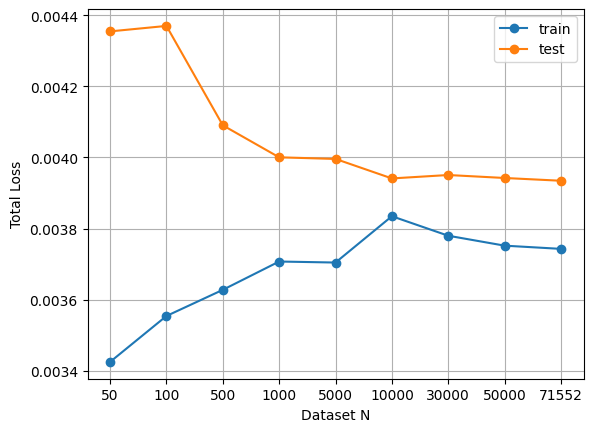

In [11]:
plt.plot(model1_train_mse_loss_list,'-o')
plt.plot(model1_test_mse_loss_list,'-o')
plt.legend(['train','test'])
plt.xticks(ticks=list(range(len(model1_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Total Loss')
plt.grid()

In [12]:
print(np.argmin(model1_test_mse_loss_list))
for i in range(len(model1_test_mse_loss_list)):
    print(i, model1_test_mse_loss_list[i])


8
0 0.004354372528795777
1 0.004369757987944571
2 0.004090303421858966
3 0.004000301439576812
4 0.00399576152352239
5 0.003940953118033225
6 0.003950538650165883
7 0.003942193653689711
8 0.003934432180152716


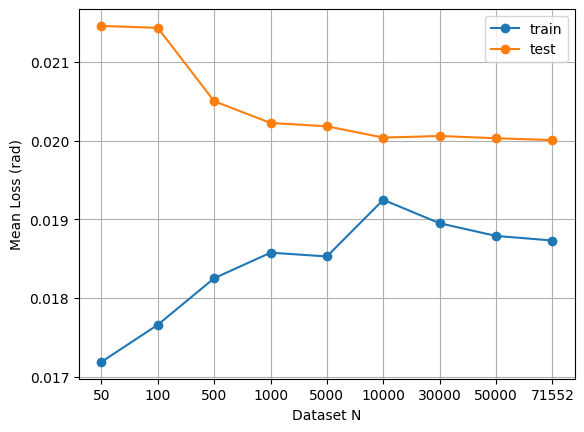

In [13]:
plt.plot(model1_train_rad_rmse_loss_list ,'-o')
plt.plot(model1_test_rad_rmse_loss_list,'-o')
plt.legend(['train','test'])
plt.xticks(ticks=list(range(len(model1_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Mean Loss (rad)')
plt.grid()

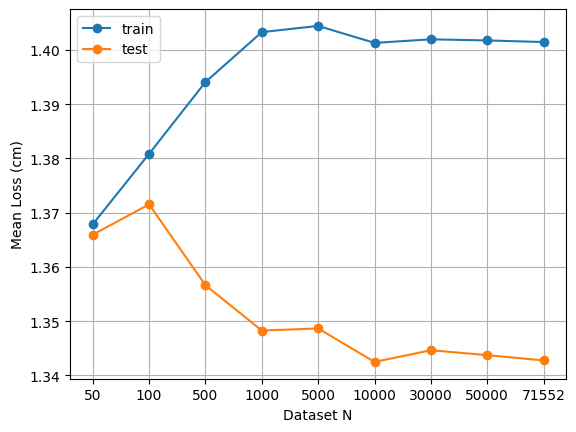

In [14]:
plt.plot(model1_train_cm_rmse_loss_list ,'-o')
plt.plot(model1_test_cm_rmse_loss_list,'-o')
plt.legend(['train','test'])
plt.xticks(ticks=list(range(len(model1_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Mean Loss (cm)')
plt.grid()

# Multiple Optimization (Model 2)

In [15]:
data_list = ['241005_075m_grace_dataset_50.csv',
            '241005_075m_grace_dataset_100.csv',
            '241005_075m_grace_dataset_500.csv',
            '241005_075m_grace_dataset_1000.csv',
            '241005_075m_grace_dataset_5000.csv',
            '241005_075m_grace_dataset_10000.csv',
            '241005_075m_grace_dataset_30000.csv',
            '241005_075m_grace_dataset_50000.csv',
            '241003_075m_grace_dataset.csv']

In [16]:
test_list = len(data_list)*['241005_075m_test_grace_dataset_1000.csv']

In [17]:
fit_list = ['20241005_151840_438087_50_075m_grace_results.csv',
           '20241005_151940_914803_100_075m_grace_results.csv',
           '20241005_152043_722636_500_075m_grace_results.csv',
           '20241005_152142_261781_1000_075m_grace_results.csv',
           '20241005_152238_017100_5000_075m_grace_results.csv',
           '20241005_152330_147819_10000_075m_grace_results.csv',
           '20241005_152442_664517_30000_075m_grace_results.csv',
           '20241005_152607_497835_50000_075m_grace_results.csv',
           '20241005_152748_279760_71552_075m_grace_results.csv']

## Train Set

In [18]:
model2_train_df_list = []
model2_train_mse_loss_list = []
model2_train_rad_rmse_loss_list = []
model2_train_cm_rmse_loss_list = []
for i in range(len(data_list)):
    temp_df = get_total_loss(data_dir="thesis", data_csv=data_list[i], fit_result=fit_list[i])
    model2_train_df_list.append(temp_df.copy())
    
    total_mse_loss = np.sum(temp_df['Left Eye MSE']) + np.sum(temp_df['Right Eye MSE'])
    model2_train_mse_loss_list.append(total_mse_loss)
    
    rad_rmse_loss = (np.sum(temp_df['Left Eye RMSE'][:3]) + np.sum(temp_df['Right Eye RMSE'][:3]))/6
    model2_train_rad_rmse_loss_list.append(rad_rmse_loss)
    
    cm_rmse_loss = (np.sum(temp_df['Left Eye RMSE'][3:]) + np.sum(temp_df['Right Eye RMSE'][3:]))/6
    model2_train_cm_rmse_loss_list.append(cm_rmse_loss)

## Test Set

In [19]:
model2_test_df_list = []
model2_test_mse_loss_list = []
model2_test_rad_rmse_loss_list = []
model2_test_cm_rmse_loss_list = []
for i in range(len(data_list)):
    temp_df = get_total_loss(data_dir="thesis", data_csv=test_list[i], fit_result=fit_list[i])
    model2_test_df_list.append(temp_df.copy())
    
    total_mse_loss = np.sum(temp_df['Left Eye MSE']) + np.sum(temp_df['Right Eye MSE'])
    model2_test_mse_loss_list.append(total_mse_loss)
    
    rad_rmse_loss = (np.sum(temp_df['Left Eye RMSE'][:3]) + np.sum(temp_df['Right Eye RMSE'][:3]))/6
    model2_test_rad_rmse_loss_list.append(rad_rmse_loss)
    
    cm_rmse_loss = (np.sum(temp_df['Left Eye RMSE'][3:]) + np.sum(temp_df['Right Eye RMSE'][3:]))/6
    model2_test_cm_rmse_loss_list.append(cm_rmse_loss)

## Plotting

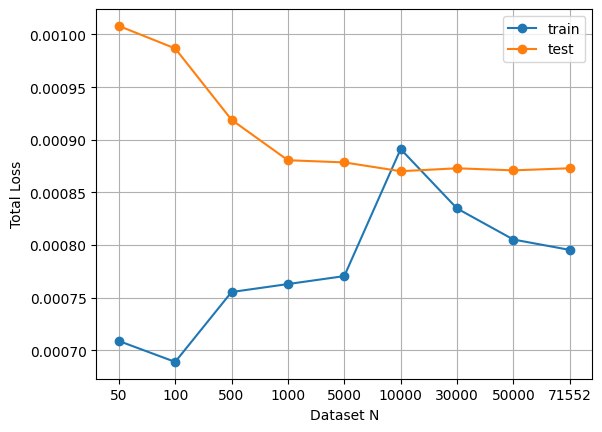

In [20]:
plt.plot(model2_train_mse_loss_list,'-o')
plt.plot(model2_test_mse_loss_list,'-o')
plt.legend(['train','test'])
plt.xticks(ticks=list(range(len(model2_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Total Loss')
plt.grid()

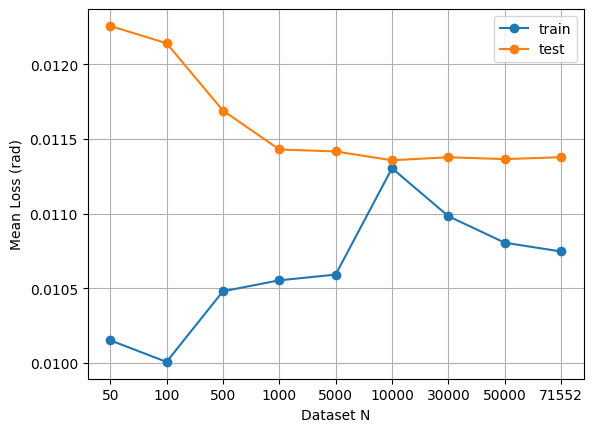

In [21]:
plt.plot(model2_train_rad_rmse_loss_list ,'-o')
plt.plot(model2_test_rad_rmse_loss_list,'-o')
plt.legend(['train','test'])
plt.xticks(ticks=list(range(len(model2_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Mean Loss (rad)')
plt.grid()

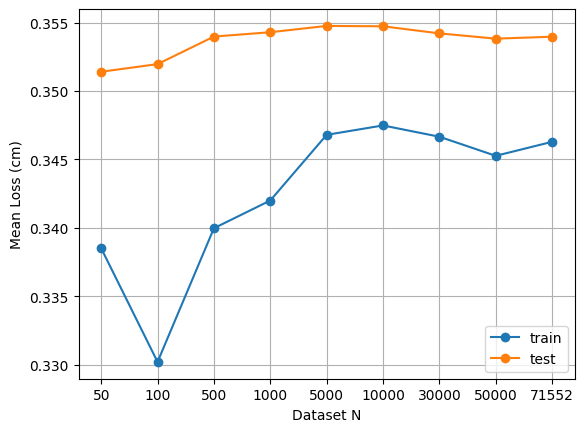

In [22]:
plt.plot(model2_train_cm_rmse_loss_list ,'-o')
plt.plot(model2_test_cm_rmse_loss_list,'-o')
plt.legend(['train','test'])
plt.xticks(ticks=list(range(len(model2_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Mean Loss (cm)')
plt.grid()

# Total Plot

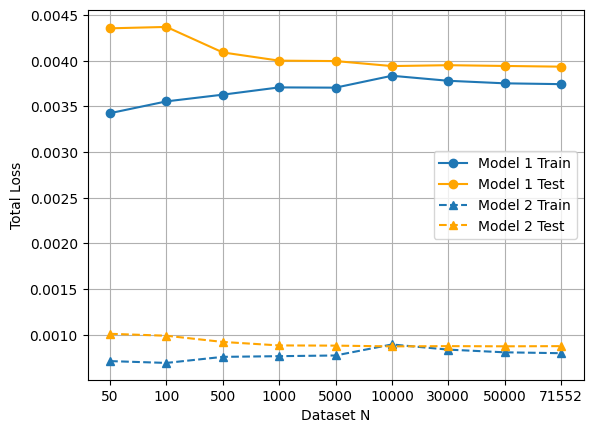

In [23]:
plt.plot(model1_train_mse_loss_list,'-o', color='#1f77b4')
plt.plot(model1_test_mse_loss_list,'-o', color='orange')
plt.plot(model2_train_mse_loss_list,'--^', color='#1f77b4')
plt.plot(model2_test_mse_loss_list,'--^', color='orange')
plt.legend(['Model 1 Train','Model 1 Test','Model 2 Train','Model 2 Test'])
plt.xticks(ticks=list(range(len(model2_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Total Loss')
plt.grid()


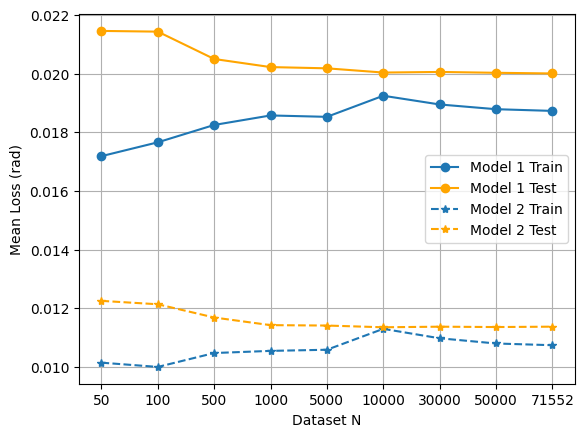

In [24]:
plt.plot(model1_train_rad_rmse_loss_list,'-o', color='#1f77b4')
plt.plot(model1_test_rad_rmse_loss_list,'-o', color='orange')
plt.plot(model2_train_rad_rmse_loss_list,'--*', color='#1f77b4')
plt.plot(model2_test_rad_rmse_loss_list,'--*', color='orange')
plt.legend(['Model 1 Train','Model 1 Test','Model 2 Train','Model 2 Test'])
plt.xticks(ticks=list(range(len(model2_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Mean Loss (rad)')
plt.grid()

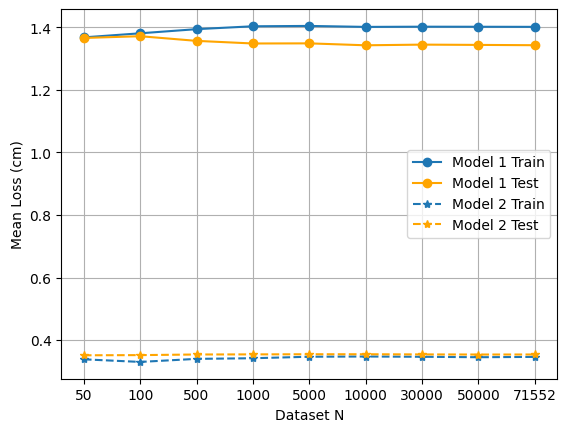

In [25]:
plt.plot(model1_train_cm_rmse_loss_list,'-o', color='#1f77b4')
plt.plot(model1_test_cm_rmse_loss_list,'-o', color='orange')
plt.plot(model2_train_cm_rmse_loss_list,'--*', color='#1f77b4')
plt.plot(model2_test_cm_rmse_loss_list,'--*', color='orange')
plt.legend(['Model 1 Train','Model 1 Test','Model 2 Train','Model 2 Test'])
plt.xticks(ticks=list(range(len(model2_train_mse_loss_list))), labels=['50','100','500','1000','5000','10000','30000','50000','71552'])
plt.xlabel('Dataset N')
plt.ylabel('Mean Loss (cm)')
plt.grid()